## Домашнее задание №1

В этом домашнем задании вы познакомитесь с pytorch сами и сможете попрактиковаться в его применении. 
#### Выполнил:
**Кувайцев Константин**
#### План:

1. Простейшие операции в pytorch
2. Пишем Adam и применяем его к ручной модели
3. Обучаем свою первую нейросеть

In [1]:
import os
import sys
import math
import torch
import random
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

### Простейшие операции на pytorch (2 балла)

**Task**: Cоздайте два случайных тензора (двумерных, не квадратных):

In [2]:
x = torch.rand(5, 4)
y = torch.rand(5, 4)

**Task**: Умножьте их друг на друга, результат запишите в третий тензор без использования оператора `=`, для создания третьего тензора предлагается использовать `torch.empty`:

In [3]:
z = torch.empty(5, 4)
torch.mul(x, y, out=z)
print(z)

tensor([[5.1530e-01, 4.2536e-01, 1.5046e-01, 6.5726e-01],
        [9.4586e-02, 1.4410e-01, 1.2770e-01, 1.2696e-02],
        [3.4205e-01, 7.2105e-01, 2.2021e-01, 2.3924e-02],
        [2.5865e-03, 8.0795e-02, 3.2605e-02, 3.7328e-01],
        [2.2457e-04, 1.6023e-01, 6.2461e-03, 6.9325e-01]])


**Task**: Реализуйте ReLU использую только pytorch, примените его к тензору `x` (запрещено использование модулей torch.nn и его подмодулей, а также функции torch.relu)

In [4]:
def relu_forward(x):
    zeros = torch.zeros_like(x, dtype=torch.float)
    return torch.where(x > 0, x, zeros)

assert torch.all(F.relu(x) == relu_forward(x))

In [5]:
# your code here 

**Task**: Сделайте тоже самое c ELU (запрещено использование модулей torch.nn и его подмодулей):

In [6]:
def elu_forward(x):
    elu = torch.exp(x)
    return torch.where(x > 0, x, elu)

assert torch.allclose(
    F.elu(x),
    elu_forward(x), 
    1e-4
)

**Task**: LeakyReLU (запрещено использование модулей torch.nn и его подмодулей):

In [7]:
def lrelu_forward(x, alpha):
    lrelu = x * alpha
    return torch.where(x > 0, x, lrelu)

assert torch.all(F.leaky_relu(x, 0.01) == lrelu_forward(x, 0.01))

**Task**: Теперь перейдем к немного более современным функциям активаций, например Mish, напомним как она выглядит:

$$x * tanh(ln(1+e^x))$$

(запрещено использование модулей torch.nn и его подмодулей)

In [8]:
def mish(x):
    tanh = torch.tanh(torch.log(1 + torch.exp(x)))
    return torch.mul(x, tanh)

In [9]:
assert torch.allclose(
    mish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.8651, 0.8651, 0.8651]), 
    atol=1e-4
)

assert torch.allclose(
    mish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.5014, 0.2908, 0.5280, 0.2663], dtype=torch.float64), 
    atol=1e-4
)

**Task**: Теперь реализуем swish, напомним как она выглядит:

$$x * \sigma(x)$$

(запрещено использование модулей torch.nn и его подмодулей)

In [10]:
def swish(x):
    sigm = torch.sigmoid(x)
    return torch.mul(x, sigm)

In [11]:
assert torch.allclose(
    swish(torch.tensor([1, 1, 1], dtype=torch.float32)), 
    torch.tensor([0.7311, 0.7311, 0.7311]), 
    atol=1e-4
)

assert torch.allclose(
    swish(torch.tensor([0.6376, 0.4021, 0.6656, 0.3726], dtype=torch.float64)), 
    torch.tensor([0.4171, 0.2409, 0.4396, 0.2206], dtype=torch.float64), 
    atol=1e-4
)

### Пишем Adam и применяем его к логистической регрессии (4 балла)


В данной секции вам нужно сделать две вещи: 

1. Написать свой собственный оптимизатор подобно тому, который мы писали на семинаре
2. Обучить логистическую регрессию побатчево на картинках из датасета 


#### Adam


$$
\begin{eqnarray}
g &=& \frac{1}{m}\nabla_w \sum_i L(f(x_{i};w), y_{i}) \\
m &=& \beta_1 m + (1 - \beta_1) g \\
v &=& \beta_2 v + (1 - \beta_2) diag(gg^{T}) \\
\hat{m} &=& \frac{m}{1 - \beta_1^{t}} \\
\hat{v} &=& \frac{v}{1 - \beta_2^{t}} \\
w &=& w - \frac{\eta}{\sqrt{\hat{v} + \epsilon}} \odot \hat{m}
\end{eqnarray}
$$

In [12]:
# абстрактный класс, не обращайте внимания
from torch.optim import Optimizer


class InClassOptimizer(Optimizer):
    def step(self):
        """Perform single optimization step."""
        with torch.no_grad(): # выключим градиенты
            for group in self.param_groups:
                self._group_step(group)

    def _group_step(self, group):
        # group ~ dict[str, ...]
        """
        Private helper function to perform
        single optimization step on model parameters.
        """
        raise NotImplementedError()

**Task**: Напишите свою реализацию Adam:

In [13]:
class Adam(InClassOptimizer):
    def __init__(self, params, lr=0.001, eps=1e-13, beta_1=0.9, beta_2=0.999):
        defaults = dict(lr=lr, eps=eps, beta_1=beta_1, beta_2=beta_2)
        self.t = 0
        super().__init__(params, defaults)

    def _group_step(self, group):
        lr = group['lr']
        eps = group['eps']
        beta_1 = group['beta_1']
        beta_2 = group['beta_2']
        
        for param in filter(lambda x: x.grad is not None, group['params']):
            d_param = param.grad
            
            self._init_m_param_buffer(param)
            self._init_v_param_buffer(param)

            self.t += 1
            m = self._get_m_param_buffer(param)
            v = self._get_v_param_buffer(param)
            
            m.mul_(beta_1)
            m.add_((1 - beta_1) * d_param)
            
            v.mul_(beta_2)
            v.add_((1 - beta_2) * d_param**2)

            m_hat = m / (1 - beta_1 ** self.t)
            v_hat = v / (1 - beta_2 ** self.t)
            
            m_hat /= torch.sqrt(v_hat + eps)
            
            param.add_(m_hat, alpha=-lr)
    
    def _get_m_param_buffer(self, param):
        param_state = self.state[param]
        return param_state['m_param_buffer']

    def _init_m_param_buffer(self, param):
        param_state = self.state[param]
        if 'm_param_buffer' not in param_state:
            param_state['m_param_buffer'] = torch.zeros_like(param)
    
    def _get_v_param_buffer(self, param):
        param_state = self.state[param]
        return param_state['v_param_buffer']

    def _init_v_param_buffer(self, param):
        param_state = self.state[param]
        if 'v_param_buffer' not in param_state:
            param_state['v_param_buffer'] = torch.zeros_like(param)

**Task**: Создайте параметры для обучения логистической регрессии, сделаем Xavier ициализацию, которая выглядит следующим образом: 

$$w \sim U[-\frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}, \frac{\sqrt{6}}{\sqrt{n_{in} + n_{out}}}]$$

где: 

* $n_{in}$ -- размер входа (в нейронах) 
* $n_{out}$ -- размер выхода (в нейронах)

Подумайте над выбором $n_{in}$ и $n_{out}$ самостоятельно. 

In [52]:
nin = 28 * 28
nout = 10
weights = torch.rand((nin, nout), requires_grad=True)
torch.nn.init.xavier_uniform_(weights)
intercept = torch.rand((1, nout), requires_grad=True)
torch.nn.init.xavier_uniform_(intercept)

weights_torch = weights.clone().detach()
weights_torch = torch.tensor(weights_torch, requires_grad=True)
intercept_torch = intercept.clone().detach()
intercept_torch = torch.tensor(intercept_torch, requires_grad=True)

<ipython-input-52-f8b2e8fd2915>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights_torch = torch.tensor(weights_torch, requires_grad=True)
<ipython-input-52-f8b2e8fd2915>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  intercept_torch = torch.tensor(intercept_torch, requires_grad=True)


In [53]:
intercept

tensor([[ 0.6538, -0.5420, -0.5302,  0.2508,  0.1155, -0.6589, -0.6616, -0.3591,
          0.6379,  0.0473]], requires_grad=True)

Загрузим данные и создадим даталоадеры:

In [54]:
fashion_mnist_train = torchvision.datasets.FashionMNIST(
    './data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
train_dataloader = DataLoader(
    fashion_mnist_train, batch_size=128, shuffle=True, num_workers=1
)

fashion_mnist_eval = torchvision.datasets.FashionMNIST(
    './data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

eval_dataloader = DataLoader(
    fashion_mnist_eval, batch_size=128, shuffle=True, num_workers=1
)

Напишите функцию для тренировки логистической регрессии, она должна: 
    * Делать предсказания 
    * Считать лосс 
    * Подсчитывать градиенты
    * Делать шаг оптимизации
    * Обнулять посчитанные градиенты
    * Считать метрики 
    * Возвращать полученные метрики
    
После этого предусмотрите возможность визуализировать метрики, чтобы нарисовать картинки, а именно от вас требуется визуализировать: 

    * Зависимость лосса от количества итераций
    * Зависимость доли правильных ответов от количества итераций

In [55]:
def model(X, w, b):
    return torch.mm(X, w) + b

In [56]:
def train_logistic_regression(weights, bias, batch, loss, optimizer):
    
    images = batch[0].view(-1, 28*28).requires_grad_()
    labels = batch[1]

    optimizer.zero_grad()
    outputs = model(images, weights, bias)
    loss_train = loss(outputs, labels)
    loss_train.backward()
    optimizer.step()
    
    accuracy, loss_ = metrics(weights, bias, loss, batch=batch, mode='train')
    
    return accuracy, loss_

In [57]:
def metrics(weights, bias, loss, dataloader=None, batch=None, mode='test'):
    correct = 0
    total = 0
    with torch.no_grad():
        if mode == 'train':
            images = batch[0].view(-1, 28*28).requires_grad_()
            labels = batch[1]
            outputs = model(images, weights, bias)
            loss_train = loss(outputs, labels)
            _, y_pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (y_pred == labels).sum()
            accuracy = 100 * float(correct) / float(total)
            
            return round(accuracy, 2), loss_train.item()
        
        else:
            loss_test = []
            for images, labels in dataloader:
                images = images.view(-1, 28*28).requires_grad_()
                outputs = model(images, weights, bias)
                loss_one = loss(outputs, labels)
                loss_test.append(loss_one)
                _, y_pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (y_pred == labels).sum()
                
            accuracy = 100 * float(correct) / float(total)
    
            return round(accuracy, 2), np.mean(loss_test)

In [58]:
def visualisation(epochs, train_acc, val_acc, train_loss, val_loss):
    rng = range(1, epochs + 1)
    
    plt.figure(figsize=(8,6))
    plt.plot(rng, train_acc, label='Train accuracy', c='blue')
    plt.plot(rng, val_acc, label='Validation accuracy', c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(8,6))
    plt.plot(rng, train_loss, label='Train loss', c='blue')
    plt.plot(rng, val_loss, label='Validation loss', c='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()

In [69]:
def optim_visualisation(param_1, param_2, label_sign):
    plt.figure(figsize=(6,4))
    plt.plot(param_1, label='My Adam ' + label_sign, c='blue')
    plt.plot(param_2, label='Pytorch Adam ' + label_sign, c='red')
    plt.xlabel('Epoch')
    plt.ylabel(label_sign.split()[1])
    plt.title(label_sign)
    plt.legend()
    plt.show()

In [59]:
def fit(optimizer, weights_fit, intercept_fit, num_epoch=10):
    total_train_accuracy = []
    total_train_loss = []
    total_val_accuracy = []
    total_val_loss = []
    epochs = num_epoch
    for epoch in range(1, epochs + 1):
        batches_accuracy = []
        batches_loss = []

        with tqdm(total=len(train_dataloader), file=sys.stdout) as prbar:
            for batch in train_dataloader:
                batch_acc, batch_l = train_logistic_regression(weights_fit, intercept_fit, batch, criterion, optimizer)
                prbar.update(1)
                batches_accuracy.append(batch_acc)
                batches_loss.append(batch_l)

        accuracy_train, error_train = round(np.mean(batches_accuracy), 2), np.mean(batches_loss)
        accuracy_val, error_val = metrics(weights_fit, intercept_fit, criterion, dataloader=eval_dataloader)

        total_train_accuracy.append(accuracy_train)
        total_train_loss.append(error_train)
        total_val_accuracy.append(accuracy_val)
        total_val_loss.append(error_val)

        print("Epoch: {}. Accuracy_train: {}. Accuracy_val: {}.".format(epoch, accuracy_train, accuracy_val))
        print("Epoch: {}. Loss_train: {}. Loss_val: {}.".format(epoch, error_train, error_val))
        print()
    
    return total_train_accuracy, total_val_accuracy, total_train_loss, total_val_loss


## My Adam

In [60]:
optimizer_Adam = Adam([weights, intercept])
criterion = nn.CrossEntropyLoss()
train_acc_1, test_acc_1, train_loss_1, test_loss_1 = fit(optimizer_Adam, weights, intercept, num_epoch=150)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 50.72it/s]
Epoch: 1. Accuracy_train: 75.37. Accuracy_val: 80.94.
Epoch: 1. Loss_train: 0.7212282286396922. Loss_val: 0.5654327869415283.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:09<00:00, 49.27it/s]
Epoch: 2. Accuracy_train: 82.97. Accuracy_val: 82.56.
Epoch: 2. Loss_train: 0.5035200363664485. Loss_val: 0.5062164068222046.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.79it/s]
Epoch: 3. Accuracy_train: 84.36. Accuracy_val: 82.94.
Epoch: 3. Loss_train: 0.4635671202434914. Loss_val: 0.49066877365112305.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 40.39it/s]
Epoch: 4. Accuracy_train: 84.99. Accuracy_val: 83.78.
Epoch: 4. Loss_train: 0.4443804022472805. Loss_val: 0.47452130913734436.

100%|█████

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.80it/s]
Epoch: 34. Accuracy_train: 87.09. Accuracy_val: 84.58.
Epoch: 34. Loss_train: 0.3670633187426179. Loss_val: 0.44106122851371765.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.31it/s]
Epoch: 35. Accuracy_train: 87.31. Accuracy_val: 84.61.
Epoch: 35. Loss_train: 0.3662525001111061. Loss_val: 0.4393147826194763.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.26it/s]
Epoch: 36. Accuracy_train: 87.23. Accuracy_val: 84.63.
Epoch: 36. Loss_train: 0.366452009280099. Loss_val: 0.43622541427612305.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 36.34it/s]
Epoch: 37. Accuracy_train: 87.18. Accuracy_val: 84.67.
Epoch: 37. Loss_train: 0.3657090603225013. Loss_val: 0.43443790078163147.

10

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.38it/s]
Epoch: 67. Accuracy_train: 87.62. Accuracy_val: 84.41.
Epoch: 67. Loss_train: 0.3541124336310287. Loss_val: 0.4424957036972046.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.09it/s]
Epoch: 68. Accuracy_train: 87.55. Accuracy_val: 84.21.
Epoch: 68. Loss_train: 0.35371839606177324. Loss_val: 0.4439246654510498.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.65it/s]
Epoch: 69. Accuracy_train: 87.57. Accuracy_val: 84.52.
Epoch: 69. Loss_train: 0.35387527869581414. Loss_val: 0.44723835587501526.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.55it/s]
Epoch: 70. Accuracy_train: 87.53. Accuracy_val: 84.47.
Epoch: 70. Loss_train: 0.3535172729604026. Loss_val: 0.4453465938568115.

1

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.05it/s]
Epoch: 100. Accuracy_train: 87.76. Accuracy_val: 84.47.
Epoch: 100. Loss_train: 0.3478549976211621. Loss_val: 0.44863900542259216.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 32.11it/s]
Epoch: 101. Accuracy_train: 87.72. Accuracy_val: 84.46.
Epoch: 101. Loss_train: 0.34788510333627526. Loss_val: 0.44524937868118286.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.21it/s]
Epoch: 102. Accuracy_train: 87.7. Accuracy_val: 84.28.
Epoch: 102. Loss_train: 0.34784085193930914. Loss_val: 0.4549414813518524.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.17it/s]
Epoch: 103. Accuracy_train: 87.71. Accuracy_val: 84.47.
Epoch: 103. Loss_train: 0.3479561054312598. Loss_val: 0.444355547428

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 42.89it/s]
Epoch: 133. Accuracy_train: 87.86. Accuracy_val: 84.14.
Epoch: 133. Loss_train: 0.34321148331358486. Loss_val: 0.4527116119861603.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 40.90it/s]
Epoch: 134. Accuracy_train: 87.89. Accuracy_val: 84.13.
Epoch: 134. Loss_train: 0.34305242765178556. Loss_val: 0.4645656645298004.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 33.23it/s]
Epoch: 135. Accuracy_train: 87.85. Accuracy_val: 84.24.
Epoch: 135. Loss_train: 0.3423312501167692. Loss_val: 0.4546721875667572.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:14<00:00, 32.45it/s]
Epoch: 136. Accuracy_train: 87.86. Accuracy_val: 84.39.
Epoch: 136. Loss_train: 0.3432539775173293. Loss_val: 0.4542882442474

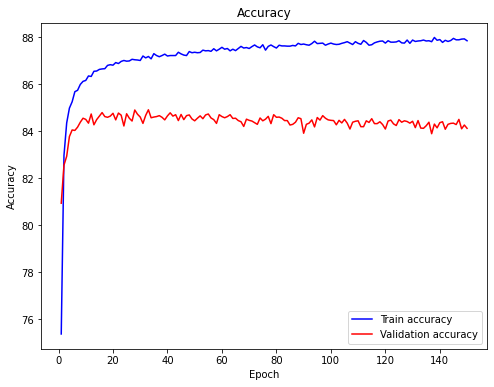

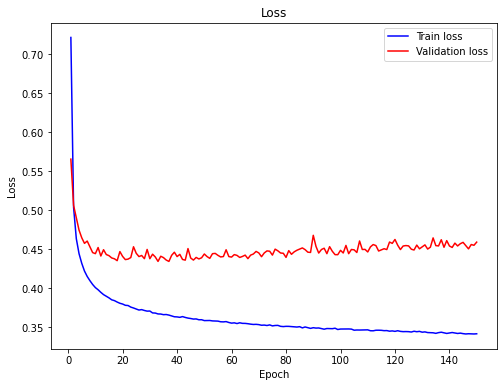

In [62]:
visualisation(150, train_acc_1, test_acc_1, train_loss_1, test_loss_1)

## Pytorch Adam

In [63]:
optimizer_torch = torch.optim.Adam([weights_torch, intercept_torch], lr=0.001, eps=1e-13, betas = (0.9, 0.999))
train_acc_2, test_acc_2, train_loss_2, test_loss_2 = fit(optimizer_torch, weights_torch, intercept_torch, num_epoch=150)

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:08<00:00, 52.64it/s]
Epoch: 1. Accuracy_train: 74.15. Accuracy_val: 79.5.
Epoch: 1. Loss_train: 0.7604682784217761. Loss_val: 0.5923076868057251.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 45.85it/s]
Epoch: 2. Accuracy_train: 82.46. Accuracy_val: 81.96.
Epoch: 2. Loss_train: 0.5233443681873492. Loss_val: 0.5240962505340576.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.41it/s]
Epoch: 3. Accuracy_train: 83.89. Accuracy_val: 83.13.
Epoch: 3. Loss_train: 0.4776248468010664. Loss_val: 0.4981096386909485.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 40.65it/s]
Epoch: 4. Accuracy_train: 84.64. Accuracy_val: 83.64.
Epoch: 4. Loss_train: 0.4536648931533797. Loss_val: 0.48074886202812195.

100%|███████

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.75it/s]
Epoch: 34. Accuracy_train: 87.09. Accuracy_val: 84.52.
Epoch: 34. Loss_train: 0.36812183210082144. Loss_val: 0.4398857653141022.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.25it/s]
Epoch: 35. Accuracy_train: 87.23. Accuracy_val: 84.66.
Epoch: 35. Loss_train: 0.3669203789249412. Loss_val: 0.44099318981170654.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 37.74it/s]
Epoch: 36. Accuracy_train: 87.13. Accuracy_val: 84.81.
Epoch: 36. Loss_train: 0.36661275083830613. Loss_val: 0.4406164288520813.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.25it/s]
Epoch: 37. Accuracy_train: 87.22. Accuracy_val: 84.71.
Epoch: 37. Loss_train: 0.3652950040757783. Loss_val: 0.4341697692871094.

1

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.30it/s]
Epoch: 67. Accuracy_train: 87.51. Accuracy_val: 84.6.
Epoch: 67. Loss_train: 0.35469716580818966. Loss_val: 0.44171634316444397.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 35.67it/s]
Epoch: 68. Accuracy_train: 87.6. Accuracy_val: 84.55.
Epoch: 68. Loss_train: 0.3550313792820933. Loss_val: 0.44088393449783325.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 36.14it/s]
Epoch: 69. Accuracy_train: 87.53. Accuracy_val: 83.53.
Epoch: 69. Loss_train: 0.35427141437398346. Loss_val: 0.46157652139663696.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:13<00:00, 34.96it/s]
Epoch: 70. Accuracy_train: 87.43. Accuracy_val: 84.45.
Epoch: 70. Loss_train: 0.35434118173778184. Loss_val: 0.446271151304245.

1

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.86it/s]
Epoch: 100. Accuracy_train: 87.74. Accuracy_val: 84.48.
Epoch: 100. Loss_train: 0.34773592361763345. Loss_val: 0.44908857345581055.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.14it/s]
Epoch: 101. Accuracy_train: 87.76. Accuracy_val: 84.47.
Epoch: 101. Loss_train: 0.3473245899623899. Loss_val: 0.45421141386032104.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:12<00:00, 38.28it/s]
Epoch: 102. Accuracy_train: 87.79. Accuracy_val: 84.41.
Epoch: 102. Loss_train: 0.34757591784000397. Loss_val: 0.45332586765289307.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.88it/s]
Epoch: 103. Accuracy_train: 87.75. Accuracy_val: 84.52.
Epoch: 103. Loss_train: 0.34661759480611604. Loss_val: 0.446111083

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 40.46it/s]
Epoch: 133. Accuracy_train: 87.83. Accuracy_val: 84.34.
Epoch: 133. Loss_train: 0.3432405987845809. Loss_val: 0.4495542049407959.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:10<00:00, 44.14it/s]
Epoch: 134. Accuracy_train: 87.87. Accuracy_val: 84.32.
Epoch: 134. Loss_train: 0.34295414521623013. Loss_val: 0.4572218954563141.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.02it/s]
Epoch: 135. Accuracy_train: 87.82. Accuracy_val: 84.43.
Epoch: 135. Loss_train: 0.3435852255966109. Loss_val: 0.45884883403778076.

100%|████████████████████████████████████████████████████████████████████████████████| 469/469 [00:11<00:00, 41.75it/s]
Epoch: 136. Accuracy_train: 87.91. Accuracy_val: 84.4.
Epoch: 136. Loss_train: 0.3427763082770142. Loss_val: 0.45671811699867

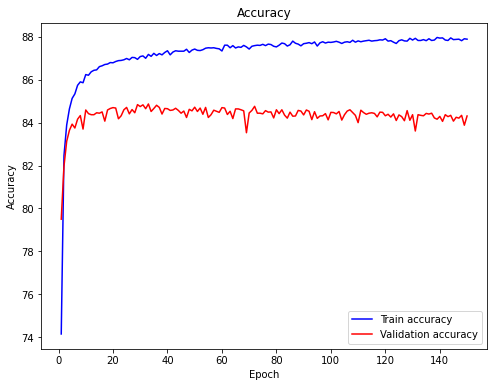

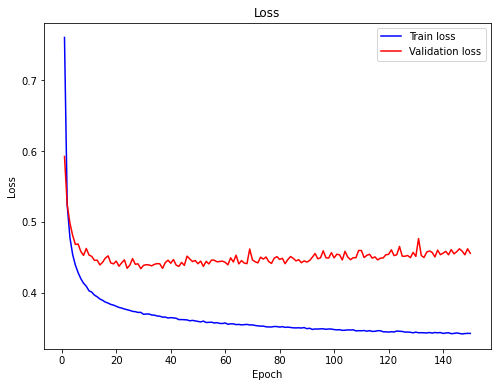

In [64]:
visualisation(150, train_acc_2, test_acc_2, train_loss_2, test_loss_2)

## Сравнение оптимизаторов

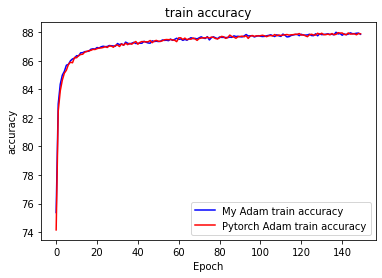

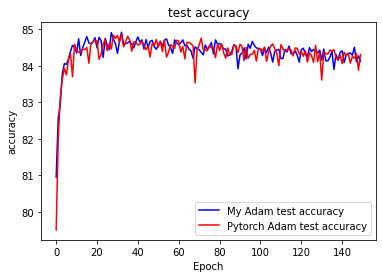

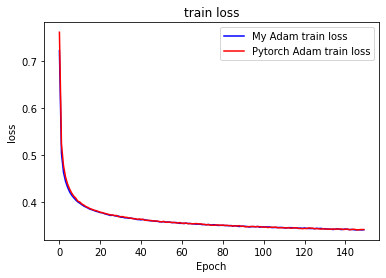

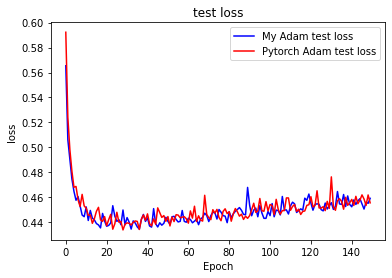

In [70]:
optim_visualisation(train_acc_1, train_acc_2, 'train accuracy')
optim_visualisation(test_acc_1, test_acc_2, 'test accuracy')
optim_visualisation(train_loss_1, train_loss_2, 'train loss')
optim_visualisation(test_loss_1, test_loss_2, 'test loss')

#### Вопросы к секции: 

* Своими словами и без математики объясните благодаря чему Adam дает несмещенную оценку на квадрат градиента
* Когда модель начала переобучаться? Как вы это поняли? Сделайте визуализацию и докажите свою точку зрения.

### 1 вопрос

Adam дает несмещенную оценку потому, что в формуле m и v с крышкой используется делитель, который при стремлении t к бесконечности стремится к 1.

### 2 вопрос

Модель начала переобучаться где-то на 50 эпохе, что хорошо видно из представленного выше графика зависимости loss'а на обучающей и тестовой выборке от номера эпохи. Это произошло из-за слишком сильной подгонки весов модели под значения обучающей выборки.

### Моя первая нейросеть (4 балла)

В данной секции вам нужно сделать следующие вещи: 

* Реализовать три разных архитектуры нейросетей. Эти архитектуры должны принципиально отличаться друг от друга. Разрешается одной из архитекур брать полностью полносвязную модель. Остальные две должны быть сверточными и сильно отличаться друг от друга. К примеру, одна из таких архитектур может быть VGG подобная сеть, а другая ResNet подобная архитектура. 

* Написать цикл для обучения которым можно обучать все три модели без изменений кода

* Попробовать каждую модель с двумя оптимизаторами: RMSprop и SGD with momentum

* Визуализировать результаты перфоманса каждой модели (две метрики минимум для каждого сетапа, например, лосс и долю правильных ответов). В данном пункте мы ждем от вас визуализацию зависимости метрики от номера итерации обучения.

* Сделать выводы какие были модели были лучше и как вы думаете почему?

In [122]:
epochs = 10
def train_model(model_def, dataloader, optimizer_def):
    epoch = 0
    total_accuracy = []
    total_loss = []
    model = model_def
    optimizer = optimizer_def
    train_dataloader = dataloader[0]
    val_dataloader = dataloader[1]
    
    for epoch in range(1, epochs + 1):
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = nn.CrossEntropyLoss()(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        if epoch % 1 == 0:
            mean_val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = nn.CrossEntropyLoss()(y_pred, y_val)
                    mean_val_loss.append(loss.numpy())
                    val_accuracy.extend(((torch.argmax(y_pred, dim=-1) == y_val) * 100).numpy().tolist())
            print('Epoch: {epoch}, loss: {loss}, accuracy: {accuracy}'.format(
                epoch=epoch, loss=np.mean(mean_val_loss), accuracy=np.mean(val_accuracy)))
    
            total_accuracy.append(np.mean(val_accuracy))
            total_loss.append(np.mean(mean_val_loss))
            
    return total_accuracy, total_loss         

In [123]:
def model_visualisation(metrics, mode):

    if mode == 'optimizers':
        plt.figure(figsize=(8,6))
        plt.plot(metrics[0], label='SGD', c='blue')
        plt.plot(metrics[2], label='RMSprop', c='red')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.show()

        plt.figure(figsize=(8,6))
        plt.plot(metrics[1], label='SGD', c='blue')
        plt.plot(metrics[3], label='RMSprop', c='red')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss')
        plt.legend()
        plt.show()

    elif mode == 'models':
        if len(metrics) == 2:
            plt.figure(figsize=(8,6))
            plt.plot(metrics[0], label='Model', c='blue')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Accuracy')
            plt.legend()
            plt.show()

            plt.figure(figsize=(8,6))
            plt.plot(metrics[1], label='Model', c='blue')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss')
            plt.legend()
            plt.show()
        else:
            plt.figure(figsize=(8,6))
            plt.plot(metrics[0], label='Model 1', c='blue')
            plt.plot(metrics[2], label='Model 2', c='red')
            plt.plot(metrics[4], label='Model 3', c='green')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.title('Accuracy')
            plt.legend()
            plt.show()

            plt.figure(figsize=(8,6))
            plt.plot(metrics[1], label='Model 1', c='blue')
            plt.plot(metrics[3], label='Model 2', c='red')
            plt.plot(metrics[5], label='Model 3', c='green')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss')
            plt.legend()
            plt.show()

## Model 1

In [124]:
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.flat(x)
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        return x

### SGD optimizer

In [125]:
model1_1 = FirstModel()
optimizer1_1 = torch.optim.SGD(model1_1.parameters(), lr=0.01, momentum=0.8)
acc1_SGD, loss1_SGD = train_model(model1_1, [train_dataloader, eval_dataloader], optimizer1_1)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 1, loss: 1.0210047960281372, accuracy: 66.33


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 2, loss: 0.9446056485176086, accuracy: 67.01


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 3, loss: 0.900436282157898, accuracy: 68.56


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 4, loss: 0.6994685530662537, accuracy: 77.15


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 5, loss: 0.6894450187683105, accuracy: 76.63


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 6, loss: 0.6547831892967224, accuracy: 77.96


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 7, loss: 0.656276524066925, accuracy: 77.88


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 8, loss: 0.628149688243866, accuracy: 78.93


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 9, loss: 0.6148894429206848, accuracy: 79.27


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 41.97it/s]

Epoch: 10, loss: 0.6217302083969116, accuracy: 79.21


### RMSprop optimizer

In [126]:
model1_2 = FirstModel()
optimizer1_2 = torch.optim.RMSprop(model1_2.parameters(), lr=0.001, alpha=0.9, eps=1e-08, momentum=0.8)
acc1_RMS, loss1_RMS = train_model(model1_2, [train_dataloader, eval_dataloader], optimizer1_2)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 1, loss: 1.302609920501709, accuracy: 56.18


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 2, loss: 1.061322808265686, accuracy: 58.49


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 3, loss: 0.884440541267395, accuracy: 65.22


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 4, loss: 0.8459506630897522, accuracy: 66.96


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 5, loss: 0.8406971096992493, accuracy: 67.91


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 6, loss: 0.8079178929328918, accuracy: 68.8


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 7, loss: 0.8269321322441101, accuracy: 68.3


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 8, loss: 0.803776741027832, accuracy: 68.91


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 9, loss: 0.8149278163909912, accuracy: 69.48


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 25.04it/s]

Epoch: 10, loss: 0.6623173952102661, accuracy: 76.58


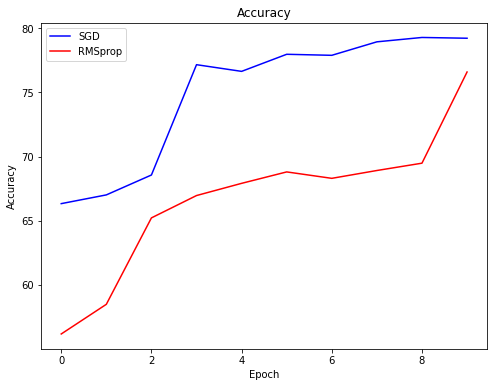

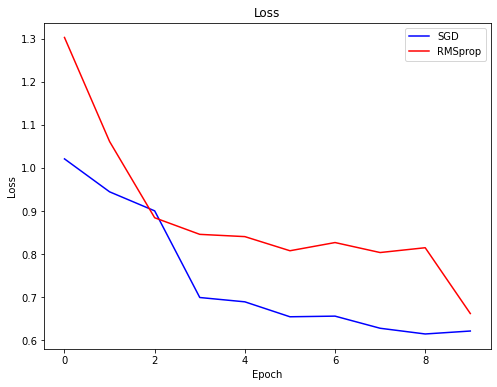

In [127]:
model_visualisation([acc1_SGD, loss1_SGD, acc1_RMS, loss1_RMS], mode='optimizers')

## Model 2

In [128]:
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()
        
        self.flat = nn.Flatten()
        self.relu = nn.ReLU()

        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)

        self.l1 = nn.Linear(12 * 4 * 4, 120)
        self.l2 = nn.Linear(120, 60)
        self.l3 = nn.Linear(60, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.flat(x)
        x = self.l1(x)
        x = self.relu(x)
        
        x = self.l2(x)
        x = self.relu(x)
        
        x = self.l3(x)

        return x

### SGD optimizer

In [129]:
model2_1 = SecondModel()
optimizer2_1 = torch.optim.SGD(model2_1.parameters(), lr=0.02, momentum=0.9)
acc2_SGD, loss2_SGD = train_model(model2_1, [train_dataloader, eval_dataloader], optimizer2_1)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 1, loss: 0.574786901473999, accuracy: 77.51


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 2, loss: 0.46497592329978943, accuracy: 83.55


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 3, loss: 0.4022490382194519, accuracy: 85.6


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 4, loss: 0.37101078033447266, accuracy: 86.68


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 5, loss: 0.3436598479747772, accuracy: 87.41


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 6, loss: 0.3457772731781006, accuracy: 87.27


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 7, loss: 0.3701082766056061, accuracy: 86.64


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 8, loss: 0.32577940821647644, accuracy: 87.72


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 9, loss: 0.32003968954086304, accuracy: 87.95


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:03<00:00, 24.98it/s]

Epoch: 10, loss: 0.3136509358882904, accuracy: 88.34


### RMSprop optimizer

In [130]:
model2_2 = SecondModel()
optimizer2_2 = torch.optim.RMSprop(model2_2.parameters(), lr=0.0005, alpha=0.99, eps=1e-08, momentum=0.8)
acc2_RMS, loss2_RMS = train_model(model2_2, [train_dataloader, eval_dataloader], optimizer2_2)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 1, loss: 0.4472610354423523, accuracy: 83.6


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 2, loss: 0.39538973569869995, accuracy: 85.58


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 3, loss: 0.3521779477596283, accuracy: 86.93


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 4, loss: 0.3375925123691559, accuracy: 87.74


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 5, loss: 0.33378803730010986, accuracy: 88.14


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 6, loss: 0.33999496698379517, accuracy: 87.71


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 7, loss: 0.30449357628822327, accuracy: 88.79


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 8, loss: 0.30535170435905457, accuracy: 89.12


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 9, loss: 0.31920501589775085, accuracy: 88.95


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.26it/s]

Epoch: 10, loss: 0.32518577575683594, accuracy: 88.76


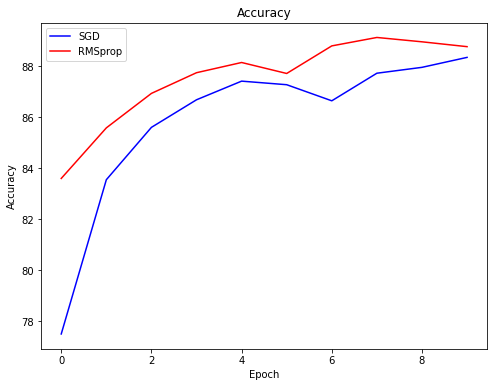

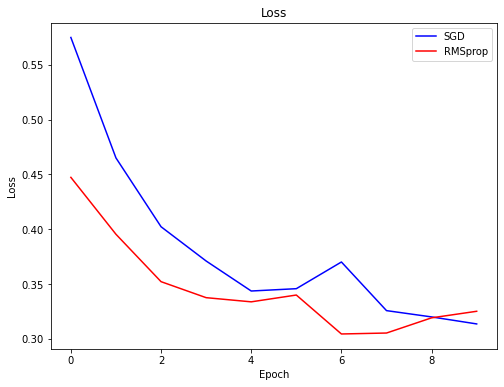

In [131]:
model_visualisation([acc2_SGD, loss2_SGD, acc2_RMS, loss2_RMS], mode='optimizers')

## Model 3

Модель взята с сайта: https://missinglink.ai/guides/pytorch/pytorch-resnet-building-training-scaling-residual-networks-pytorch/
. Если так нельзя, то считайте, что третей модели нет. Я просто хотел поэкспериментировать.

In [132]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [133]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [134]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 6

        self.conv1 = nn.Conv2d(1, 6, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(6)
        self.flat = nn.Flatten()
        self.layer1 = self._make_layer(block, 6, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 12, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 24, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 48, num_blocks[3], stride=2)
        self.linear1 = nn.Linear(48*block.expansion, 48)
        self.linear2 = nn.Linear(48, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = self.flat(out)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

### SGD optimizer

In [135]:
model3_1 = ResNet(Bottleneck, [2, 5, 3, 2])
optimizer3_1 = torch.optim.SGD(model3_1.parameters(), lr=0.02, momentum=0.9)
acc3_SGD, loss3_SGD = train_model(model3_1, [train_dataloader, eval_dataloader], optimizer3_1)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 1, loss: 0.3667076826095581, accuracy: 86.66


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 2, loss: 0.30477118492126465, accuracy: 88.15


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 3, loss: 0.26669055223464966, accuracy: 90.47


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 4, loss: 0.23369762301445007, accuracy: 91.59


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 5, loss: 0.2503302991390228, accuracy: 91.02


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 6, loss: 0.23523353040218353, accuracy: 91.95


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 7, loss: 0.2319519966840744, accuracy: 91.93


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 8, loss: 0.23955710232257843, accuracy: 91.88


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 9, loss: 0.2505738139152527, accuracy: 91.42


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:41<00:00,  1.92it/s]

Epoch: 10, loss: 0.24306561052799225, accuracy: 91.74


### RMSprop optimizer

In [136]:
model3_2 = ResNet(Bottleneck, [2, 5, 3, 2])
optimizer3_2 = torch.optim.RMSprop(model3_2.parameters(), lr=0.0005, alpha=0.99, eps=1e-08, momentum=0.8)
acc3_RMS, loss3_RMS = train_model(model3_2, [train_dataloader, eval_dataloader], optimizer3_2)

  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 1, loss: 0.3607495129108429, accuracy: 86.72


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 2, loss: 0.30965322256088257, accuracy: 88.87


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 3, loss: 0.2851821184158325, accuracy: 89.71


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 4, loss: 0.26158407330513, accuracy: 90.26


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 5, loss: 0.27220848202705383, accuracy: 90.07


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 6, loss: 0.24537216126918793, accuracy: 91.48


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 7, loss: 0.2678825855255127, accuracy: 90.91


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 8, loss: 0.2531391680240631, accuracy: 91.1


  0%|                                                                                          | 0/469 [00:00<?, ?it/s]

Epoch: 9, loss: 0.28068238496780396, accuracy: 90.45


100%|██████████████████████████████████████████████████████████████████████████████████| 79/79 [00:38<00:00,  2.04it/s]

Epoch: 10, loss: 0.2543295919895172, accuracy: 91.65


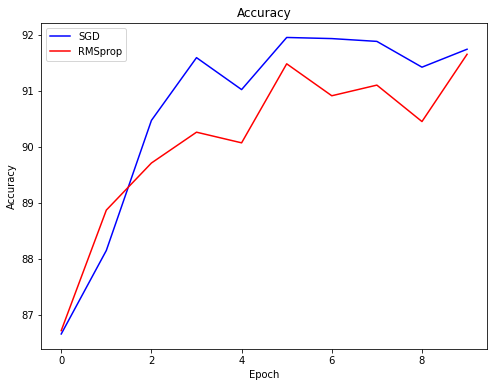

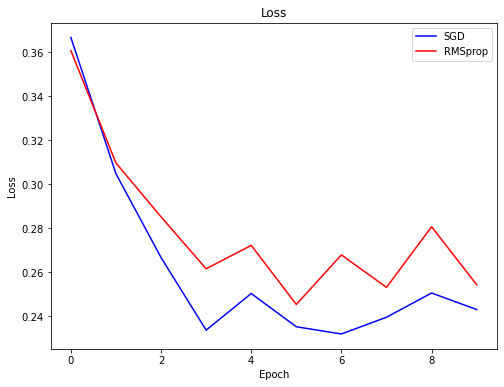

In [137]:
model_visualisation([acc3_SGD, loss3_SGD, acc3_RMS, loss3_RMS], mode='optimizers')

## Сравнение моделей

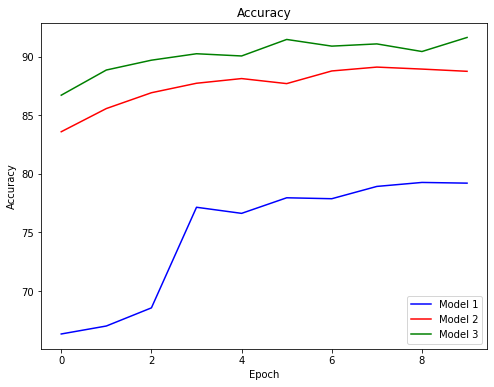

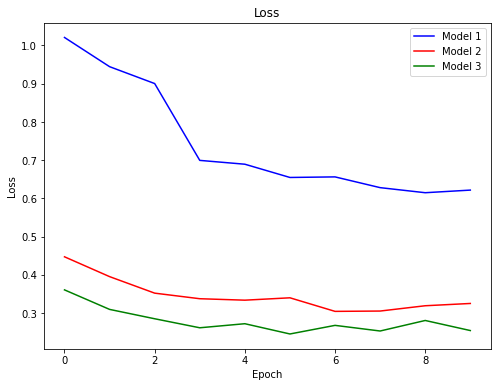

In [138]:
model_visualisation([acc1_SGD, loss1_SGD, acc2_RMS, loss2_RMS, acc3_RMS, loss3_RMS], 'models')

# Выводы

На 10 эпохах обучения с заданными не самым лучшим образом гиперпараметрами лучшие результаты показала **Resnet подобная** сеть с SGD оптимизатором. Однако, данная архитектура не очень эффективна с точки зрения вычислительных потребностей для решения нашей задачи классификации. Поэтому победителем в соревновании моделей становится **Сверточная сеть** с RMSprop оптимизатором, которая за 10 эпох смогла обучиться различать классы на картинках с точностью 89 процентов всего лишь за 3 минуты.